In [1]:
# %% [code]
# Import standard libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import PyTorch and related modules
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

# Import torchvision for the MNIST dataset
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

# Import additional libraries for clustering (later we'll use DBSCAN)
from sklearn.cluster import DBSCAN

# Import custom modules for normalizing flows (make sure nflib is in your PYTHONPATH)
from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# Enable auto-reload for easier development
%load_ext autoreload
%autoreload 2

print("Environment setup complete!")


Environment setup complete!


In [2]:
# %% [code]
import numpy as np
import torch
from torchvision import datasets

def mnist_to_pointcloud(threshold=0, noise_std=0.1):
    """
    Downloads the MNIST dataset and converts each image into a point cloud by extracting
    the coordinates of pixels above a given threshold.
    
    Optionally, Gaussian noise is added to the coordinates.
    
    Args:
        threshold (int): Pixel values above this threshold are considered active.
        noise_std (float): Standard deviation of Gaussian noise to add.
        
    Returns:
        pointclouds (list of np.ndarray): Each element is an array of shape [N, 2] containing (row, col) coordinates.
        labels (list of int): Corresponding MNIST labels for each point cloud.
    """
    # Download the MNIST training dataset
    mnist_train = datasets.MNIST(root='.', train=True, download=True)
    
    pointclouds = []
    labels = []
    
    for img, label in mnist_train:
        img_array = np.array(img)  # shape: (28, 28)
        row_indices, col_indices = np.where(img_array > threshold)
        coords = np.stack((row_indices, col_indices), axis=-1).astype(float)
        if noise_std > 0:
            noise = np.random.normal(loc=0.0, scale=noise_std, size=coords.shape)
            coords += noise
        pointclouds.append(coords)
        labels.append(label)
    
    return pointclouds, labels

def convert_pointclouds_to_tensor(pointclouds, pad_value=0.0):
    """
    Converts a list of point clouds (each with shape [N, 2]) to a padded PyTorch tensor.
    
    Args:
        pointclouds (list of np.ndarray): List where each element is a point cloud.
        pad_value (float): Value to use for padding shorter point clouds.
        
    Returns:
        padded_tensor (torch.Tensor): Tensor of shape [num_clouds, max_points, 2] containing padded point clouds.
        lengths (torch.Tensor): Tensor containing the original number of points for each point cloud.
    """
    max_points = max(pc.shape[0] for pc in pointclouds)
    num_clouds = len(pointclouds)
    padded_tensor = torch.full((num_clouds, max_points, 2), pad_value, dtype=torch.float32)
    lengths = []
    
    for i, pc in enumerate(pointclouds):
        num_points = pc.shape[0]
        lengths.append(num_points)
        padded_tensor[i, :num_points, :] = torch.from_numpy(pc.astype(np.float32))
    
    return padded_tensor, torch.tensor(lengths)

print("Conversion functions defined!")


Conversion functions defined!


In [3]:
# %% [code]
from torch.utils.data import Dataset

class MNISTPointCloudDataset(Dataset):
    """
    A PyTorch Dataset that converts MNIST images into point clouds.
    
    Each sample is a tuple: (padded_pointcloud, label, original_length)
    """
    def __init__(self, threshold=0, noise_std=0.1):
        # Convert MNIST images to point clouds and extract labels
        self.pointclouds, self.labels = mnist_to_pointcloud(threshold, noise_std)
        # Pad the point clouds so they all have the same shape
        self.padded_pointclouds, self.lengths = convert_pointclouds_to_tensor(self.pointclouds)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.padded_pointclouds[idx], self.labels[idx], self.lengths[idx]

# Create an instance of the dataset for testing
dataset = MNISTPointCloudDataset(threshold=0, noise_std=0.2)
print("Dataset length:", len(dataset))
sample, label, length = dataset[0]
print("First sample details:")
print("  - Label:", label)
print("  - Padded tensor shape:", sample.shape)
print("  - Original number of points:", length)


Dataset length: 60000
First sample details:
  - Label: 5
  - Padded tensor shape: torch.Size([351, 2])
  - Original number of points: tensor(166)


In [4]:
# %% [code]
import matplotlib.pyplot as plt
import torch

def visualize_pointcloud(pointcloud, title="Point Cloud"):
    """
    Visualize a single point cloud using matplotlib.
    
    Expects pointcloud to be a NumPy array or a Torch tensor of shape [N, 2].
    The y-axis is inverted to match typical image coordinates.
    """
    if isinstance(pointcloud, torch.Tensor):
        pointcloud = pointcloud.detach().cpu().numpy()
    plt.figure(figsize=(4, 4))
    plt.scatter(pointcloud[:, 1], -pointcloud[:, 0], s=5, alpha=0.5)
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


Collected 1000 point clouds for digit 0
Saved digit 0 point clouds to 'digit0_pointclouds.pkl'


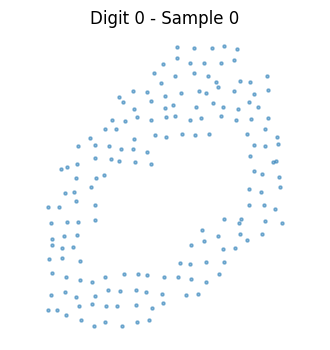

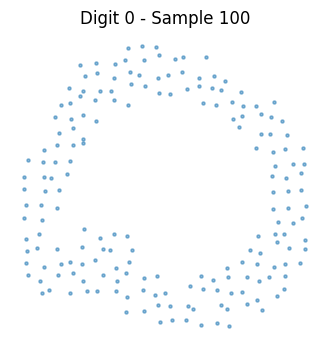

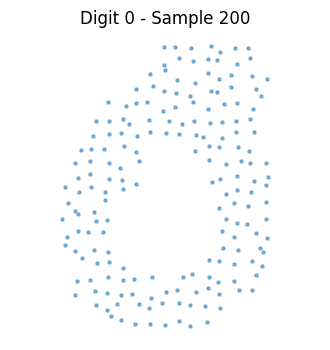

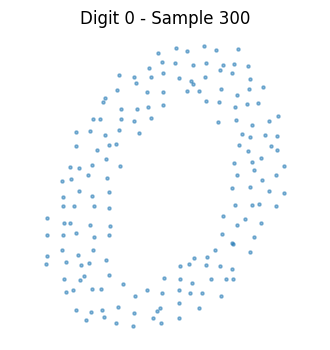

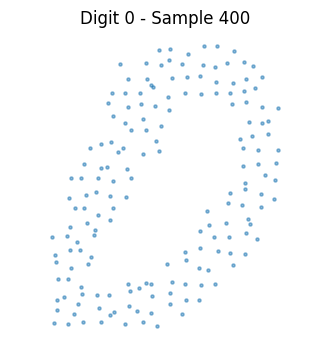

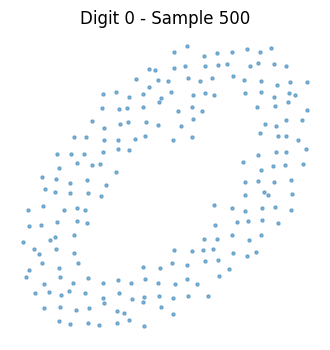

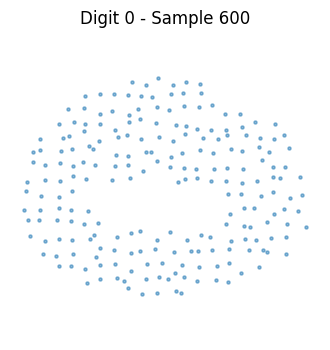

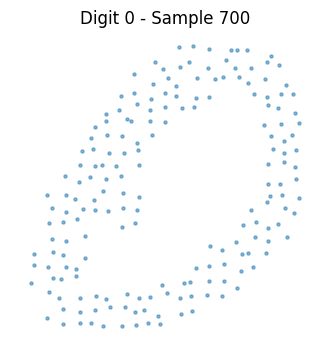

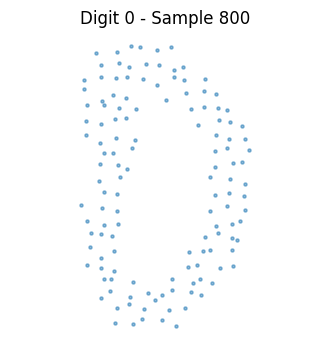

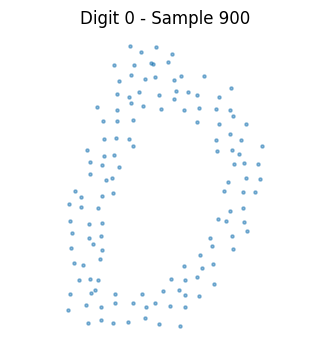

In [5]:
# %% [code]
import pickle
import numpy as np

# Collect the first 100 point clouds for digit 0
digit0_pointclouds = []

for idx in range(len(dataset)):
    padded, label, length = dataset[idx]
    if label == 0:
        # Convert to numpy array to save memory and ease serialization
        pointcloud = padded[:length].detach().cpu().numpy()
        digit0_pointclouds.append(pointcloud)
    if len(digit0_pointclouds) >= 1000:
        break

print(f"Collected {len(digit0_pointclouds)} point clouds for digit 0")

# Save the list of point clouds to a pickle file
with open('digit0_pointclouds.pkl', 'wb') as f:
    pickle.dump(digit0_pointclouds, f)
print("Saved digit 0 point clouds to 'digit0_pointclouds.pkl'")

# Visualize every 10th point cloud
for i in range(0, len(digit0_pointclouds), 100):
    visualize_pointcloud(digit0_pointclouds[i], title=f"Digit 0 - Sample {i}")


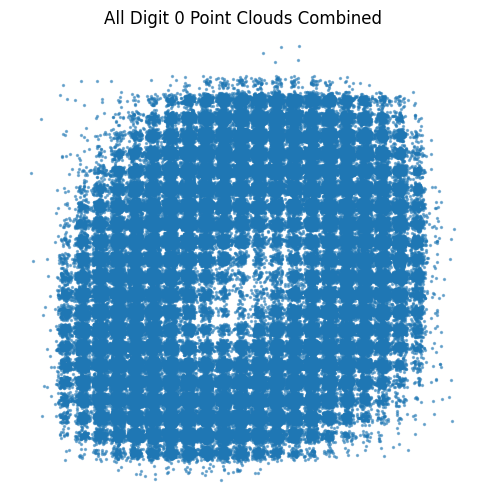

In [6]:
# %% [code]
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the saved point clouds for digit 0 from the pickle file
with open('digit0_pointclouds.pkl', 'rb') as f:
    digit0_pointclouds = pickle.load(f)

# Concatenate all point clouds along the first axis to group all points together
all_points = np.concatenate(digit0_pointclouds, axis=0)

# Visualize the combined point clouds in a single scatter plot
plt.figure(figsize=(6,6))
plt.scatter(all_points[:, 1], -all_points[:, 0], s=2, alpha=0.5)
plt.title("All Digit 0 Point Clouds Combined")
plt.axis('equal')
plt.axis('off')
plt.show()


Total number of points in concatenated digit 0 point clouds: 194879


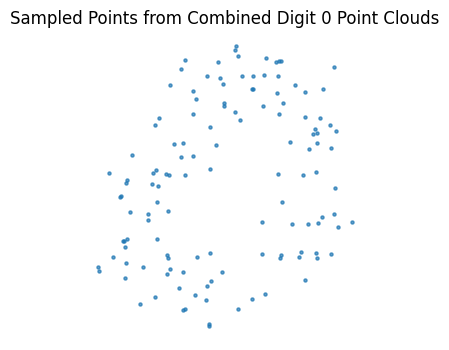

In [7]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load the saved point clouds for digit 0 from the pickle file
with open('digit0_pointclouds.pkl', 'rb') as f:
    digit0_pointclouds = pickle.load(f)

# Concatenate all point clouds together to form one large set of points
all_points = np.concatenate(digit0_pointclouds, axis=0)
print("Total number of points in concatenated digit 0 point clouds:", all_points.shape[0])

# Randomly sample 128 points from the concatenated point cloud
num_sample = 128
indices = np.random.choice(all_points.shape[0], size=num_sample, replace=False)
sampled_points = all_points[indices]

# Visualize the sampled points
plt.figure(figsize=(4, 4))
plt.scatter(sampled_points[:, 1], -sampled_points[:, 0], s=5, alpha=0.7)
plt.title("Sampled Points from Combined Digit 0 Point Clouds")
plt.axis('equal')
plt.axis('off')
plt.show()


In [9]:
# %% [code]
import itertools
import torch
import torch.optim as optim
from torch.distributions import Uniform, TransformedDistribution, SigmoidTransform
from nflib.flows import NormalizingFlowModel, Invertible1x1Conv, ActNorm
from nflib.spline_flows import NSF_CL

# Load the concatenated digit 0 point clouds and convert to a tensor
import pickle
import numpy as np

with open('digit0_pointclouds.pkl', 'rb') as f:
    digit0_pointclouds = pickle.load(f)
all_points = np.concatenate(digit0_pointclouds, axis=0)
print("Total number of points in combined digit 0 point clouds:", all_points.shape[0])
all_points_tensor = torch.from_numpy(all_points.astype(np.float32))

# Build the prior distribution (logistic-like)
prior = TransformedDistribution(
    Uniform(torch.zeros(2), torch.ones(2)),
    SigmoidTransform().inv
)

# Construct flow layers using neural spline flows (NSF_CL) with Invertible1x1Conv and ActNorm layers
nfs_flow = NSF_CL
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flow_layers = list(itertools.chain(*zip(norms, convs, flows)))

# Construct the overall model
model = NormalizingFlowModel(prior, flow_layers)

# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("Number of parameters in the model:", sum(p.numel() for p in model.parameters()))

# Training loop
model.train()
num_iterations = 10000  # You can adjust this number as needed

for i in range(num_iterations):
    # Randomly sample 128 points from the combined digit 0 point cloud tensor
    indices = torch.randint(0, all_points_tensor.shape[0], (128,))
    x = all_points_tensor[indices]
    
    # Forward pass through the model
    zs, prior_logprob, log_det = model(x)
    loss = -torch.sum(prior_logprob + log_det)  # Negative log-likelihood
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.2f}")


Total number of points in combined digit 0 point clouds: 194879
Number of parameters in the model: 5844
Iteration 0: Loss = 864.60
Iteration 100: Loss = 831.70
Iteration 200: Loss = 826.17
Iteration 300: Loss = 791.65
Iteration 400: Loss = 792.86
Iteration 500: Loss = 785.16
Iteration 600: Loss = 783.04
Iteration 700: Loss = 782.42
Iteration 800: Loss = 783.47
Iteration 900: Loss = 774.01
Iteration 1000: Loss = 775.30
Iteration 1100: Loss = 772.99
Iteration 1200: Loss = 780.59
Iteration 1300: Loss = 765.44
Iteration 1400: Loss = 761.89
Iteration 1500: Loss = 766.63
Iteration 1600: Loss = 751.62
Iteration 1700: Loss = 774.16
Iteration 1800: Loss = 742.82
Iteration 1900: Loss = 759.15
Iteration 2000: Loss = 767.81
Iteration 2100: Loss = 766.85
Iteration 2200: Loss = 764.06
Iteration 2300: Loss = 751.63
Iteration 2400: Loss = 751.69
Iteration 2500: Loss = 757.36
Iteration 2600: Loss = 755.49
Iteration 2700: Loss = 760.24
Iteration 2800: Loss = 749.31
Iteration 2900: Loss = 745.96
Iteratio

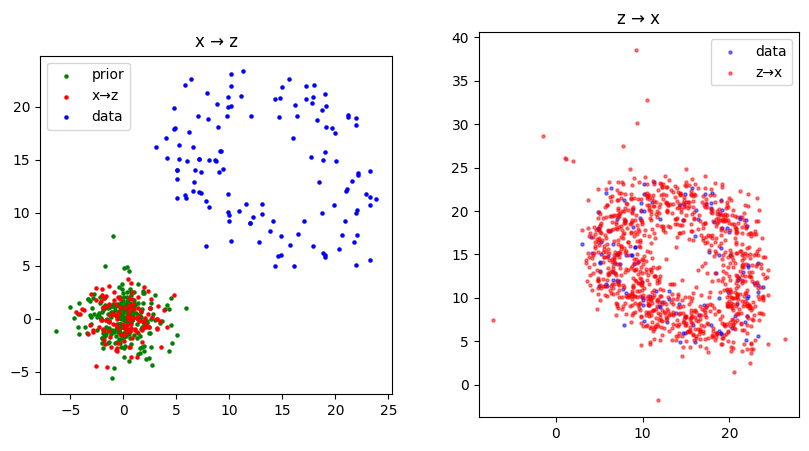

In [10]:
# %% [code]
import matplotlib.pyplot as plt

model.eval()

# Sample 128 random points from our combined digit 0 point clouds
indices = torch.randint(0, all_points_tensor.shape[0], (128,))
x = all_points_tensor[indices]

# Forward pass: Map x -> latent space z
zs, prior_logprob, log_det = model(x)
z = zs[-1]

# Convert to NumPy for visualization
x_np = x.detach().cpu().numpy()
z_np = z.detach().cpu().numpy()
p = model.prior.sample((128, 2)).squeeze().detach().cpu().numpy()

plt.figure(figsize=(10, 5))

# Left plot: x -> z mapping
plt.subplot(121)
plt.scatter(p[:, 0], p[:, 1], c='g', s=5)
plt.scatter(z_np[:, 0], z_np[:, 1], c='r', s=5)
plt.scatter(x_np[:, 0], x_np[:, 1], c='b', s=5)
plt.legend(['prior', 'x→z', 'data'])
plt.axis('scaled')
plt.title('x → z')

# Right plot: Generate new samples: z -> x mapping
zs_sample = model.sample(128 * 8)
z_sample = zs_sample[-1].detach().cpu().numpy()

plt.subplot(122)
plt.scatter(x_np[:, 0], x_np[:, 1], c='b', s=5, alpha=0.5)
plt.scatter(z_sample[:, 0], z_sample[:, 1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z→x'])
plt.axis('scaled')
plt.title('z → x')

plt.show()


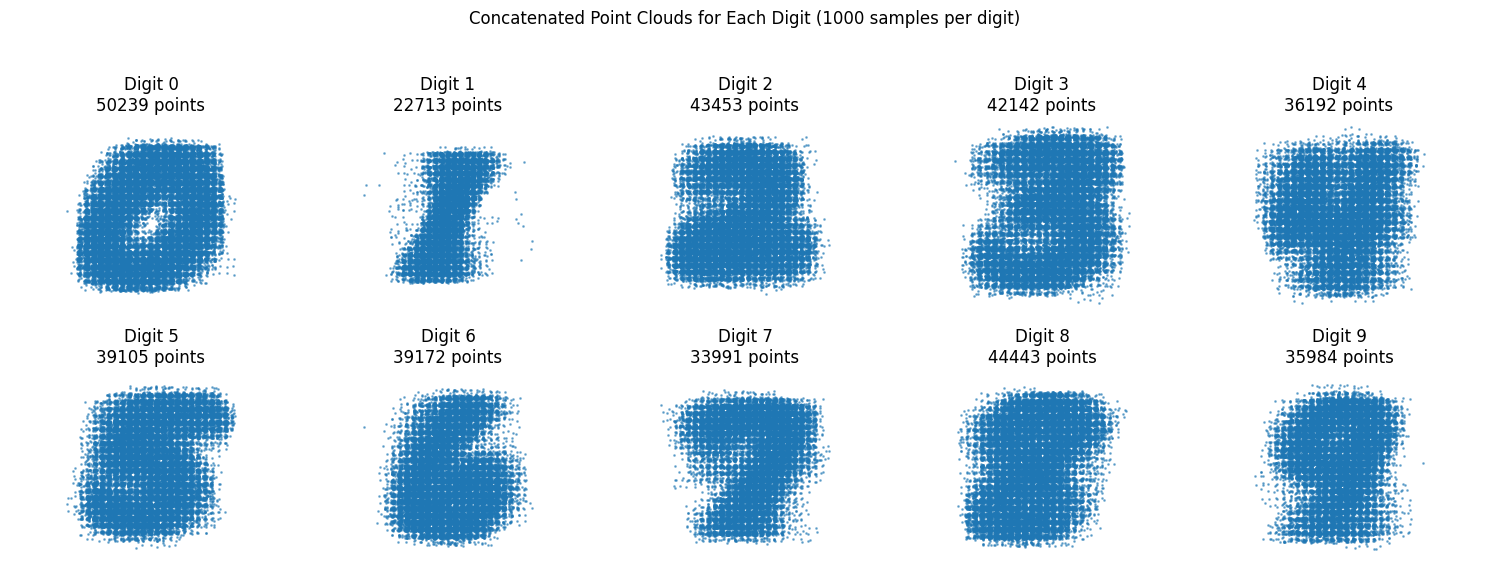

In [12]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Create a dictionary to store point clouds for each digit (0 to 9)
digit_pointclouds = {d: [] for d in range(10)}

# Iterate over the dataset and collect 1000 point clouds for each digit
for idx in range(len(dataset)):
    padded, label, length = dataset[idx]
    # Check if we have already collected 1000 for this digit
    if len(digit_pointclouds[label]) < 256:
        # Convert only the valid points to a NumPy array
        pointcloud = padded[:length].detach().cpu().numpy()
        digit_pointclouds[label].append(pointcloud)
    # If we've collected 1000 for all digits, we can stop
    if all(len(digit_pointclouds[d]) >= 256 for d in range(10)):
        break

# Optionally, save the collected point clouds (uncomment if desired)
# with open('all_digit_pointclouds.pkl', 'wb') as f:
#     pickle.dump(digit_pointclouds, f)
# print("Saved all digit point clouds to 'all_digit_pointclouds.pkl'")

# Now, for each digit, group (concatenate) all 1000 point clouds together and visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for d in range(10):
    # Concatenate all point clouds for digit d along axis 0 (each row is a point)
    all_points = np.concatenate(digit_pointclouds[d], axis=0)
    axes[d].scatter(all_points[:, 1], -all_points[:, 0], s=1, alpha=0.5)
    axes[d].set_title(f"Digit {d}\n{all_points.shape[0]} points")
    axes[d].axis('equal')
    axes[d].axis('off')

plt.suptitle("Concatenated Point Clouds for Each Digit (1000 samples per digit)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


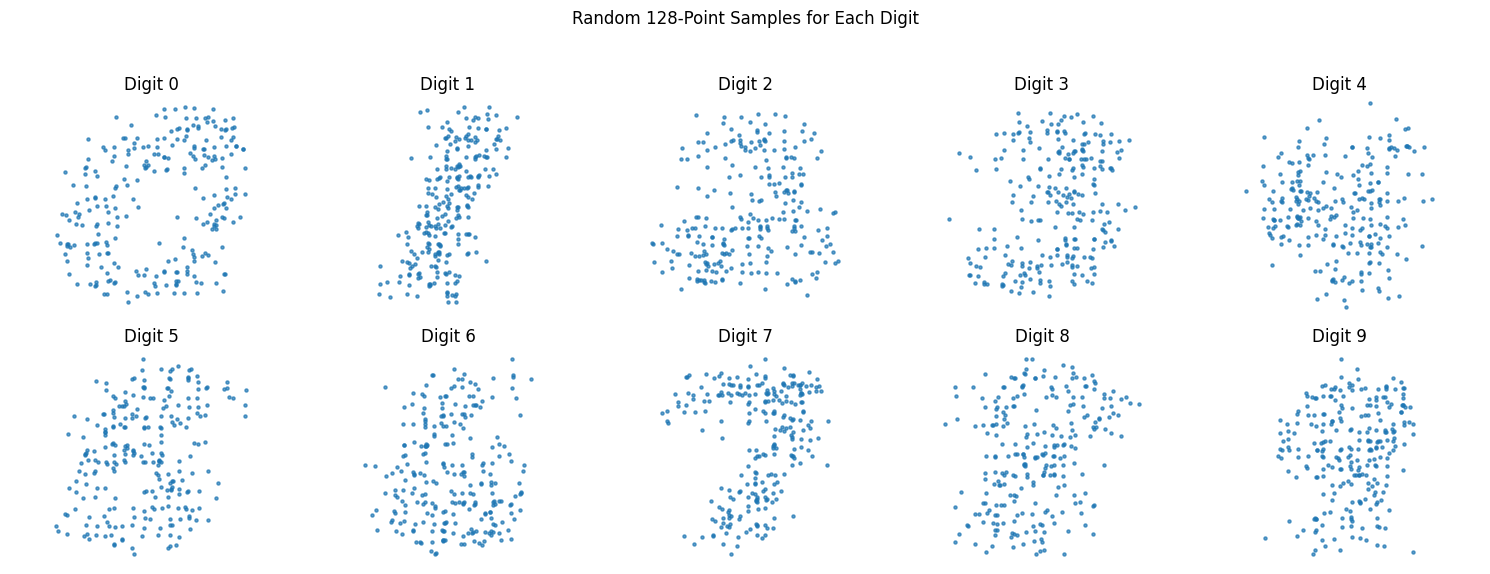

In [13]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

# Assume digit_pointclouds is already defined as a dictionary with keys 0-9,
# where each value is a list of point clouds (each a NumPy array) for that digit.
# If not already defined, you can load it from a pickle file, e.g.:
# import pickle
# with open('all_digit_pointclouds.pkl', 'rb') as f:
#     digit_pointclouds = pickle.load(f)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for d in range(10):
    # Concatenate the 1000 point clouds for this digit
    all_points = np.concatenate(digit_pointclouds[d], axis=0)
    # Randomly sample 128 points from the concatenated point cloud
    indices = np.random.choice(all_points.shape[0], size=256, replace=False)
    sampled_points = all_points[indices]
    
    # Plot the sampled points
    axes[d].scatter(sampled_points[:, 1], -sampled_points[:, 0], s=5, alpha=0.7)
    axes[d].set_title(f"Digit {d}")
    axes[d].axis('equal')
    axes[d].axis('off')

plt.suptitle("Random 128-Point Samples for Each Digit")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


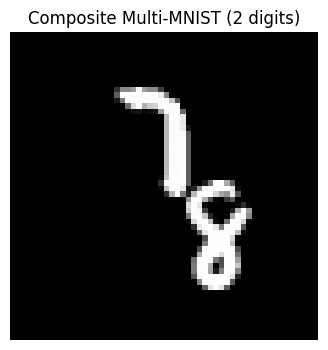

Converted 1000 composite images to point clouds.
Saved composite multi-MNIST point clouds (2 digits per image) to 'multi_mnist_composite_pointclouds_2digits.pkl'


In [16]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torchvision import datasets

def generate_multi_mnist_image(mnist_dataset, num_digits=2, canvas_size=(56,56), digit_size=(28,28)):
    """
    Generate a composite image by randomly placing `num_digits` MNIST images on a blank canvas.
    
    Args:
        mnist_dataset: A torchvision MNIST dataset.
        num_digits (int): Number of digits to place (here 2).
        canvas_size (tuple): Size of the composite canvas (height, width).
        digit_size (tuple): Expected size of each MNIST digit image.
        
    Returns:
        canvas (np.ndarray): Composite image as a 2D uint8 array.
        positions (list): List of (x_offset, y_offset) positions where each digit was placed.
    """
    canvas = np.zeros(canvas_size, dtype=np.uint8)
    positions = []
    for _ in range(num_digits):
        # Randomly select a digit image from the MNIST dataset
        idx = np.random.randint(0, len(mnist_dataset))
        img, label = mnist_dataset[idx]
        image_np = np.array(img)  # shape: (28,28)
        # Choose a random location such that the digit fits on the canvas.
        max_x = canvas_size[1] - digit_size[1]
        max_y = canvas_size[0] - digit_size[0]
        x_offset = np.random.randint(0, max_x + 1)
        y_offset = np.random.randint(0, max_y + 1)
        # Place the digit on the canvas (use maximum to handle overlapping areas)
        canvas[y_offset:y_offset+digit_size[0], x_offset:x_offset+digit_size[1]] = \
            np.maximum(canvas[y_offset:y_offset+digit_size[0], x_offset:x_offset+digit_size[1]], image_np)
        positions.append((x_offset, y_offset))
    return canvas, positions

# Load the MNIST training dataset
mnist_dataset = datasets.MNIST(root='.', train=True, download=True)

# Generate composite multi-MNIST images with 2 digits per image.
num_composites = 1000
multi_mnist_images = []
for i in range(num_composites):
    canvas, positions = generate_multi_mnist_image(mnist_dataset, num_digits=2, canvas_size=(56,56))
    multi_mnist_images.append(canvas)

# Visualize one composite image as a sanity check
plt.figure(figsize=(4,4))
plt.imshow(multi_mnist_images[0], cmap='gray')
plt.title("Composite Multi-MNIST (2 digits)")
plt.axis('off')
plt.show()

# Conversion function to convert an image to a point cloud (same as used above)
def image_to_pointcloud(image, threshold=0, noise_std=0.1):
    """
    Convert an image to a point cloud by extracting (row, col) coordinates of pixels
    with values above the threshold and optionally adding Gaussian noise.
    
    Args:
        image (np.ndarray): 2D image array.
        threshold (int): Pixel threshold.
        noise_std (float): Noise standard deviation.
        
    Returns:
        np.ndarray: Array of shape [N, 2] with point coordinates.
    """
    row_indices, col_indices = np.where(image > threshold)
    coords = np.stack((row_indices, col_indices), axis=-1).astype(np.float32)
    if noise_std > 0:
        noise = np.random.normal(loc=0.0, scale=noise_std, size=coords.shape)
        coords += noise
    return coords

# Convert each composite image into a point cloud
multi_mnist_pointclouds = []
for img in multi_mnist_images:
    pc = image_to_pointcloud(img, threshold=0, noise_std=0.0)
    multi_mnist_pointclouds.append(pc)

print(f"Converted {len(multi_mnist_pointclouds)} composite images to point clouds.")

# Save the list of point clouds to a pickle file
with open("multi_mnist_composite_pointclouds_2digits.pkl", "wb") as f:
    pickle.dump(multi_mnist_pointclouds, f)
print("Saved composite multi-MNIST point clouds (2 digits per image) to 'multi_mnist_composite_pointclouds_2digits.pkl'")


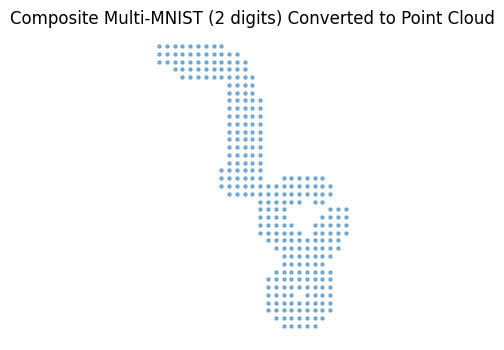

In [17]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

# Here we assume that you have already generated the composite multi-MNIST images
# with 2 digits per image in the previous cell and stored them in the list `multi_mnist_images`.
# If you haven't, you can regenerate them as shown in the previous cell.
#
# We'll reuse the conversion logic from our earlier function (adapted for any image).

def image_to_pointcloud(image, threshold=0, noise_std=0.1):
    """
    Convert an image to a point cloud by extracting the (row, col) coordinates
    of pixels with values above the threshold.
    
    Args:
        image (np.ndarray): 2D image array.
        threshold (int): Pixels above this value are considered 'on'.
        noise_std (float): Standard deviation for Gaussian noise.
        
    Returns:
        np.ndarray: Array of shape [N, 2] with (row, col) coordinates.
    """
    row_indices, col_indices = np.where(image > threshold)
    coords = np.stack((row_indices, col_indices), axis=-1).astype(np.float32)
    if noise_std > 0:
        noise = np.random.normal(loc=0.0, scale=noise_std, size=coords.shape)
        coords += noise
    return coords

# For demonstration, convert the first composite multi-MNIST image to a point cloud.
composite_image = multi_mnist_images[0]  # Assuming multi_mnist_images is defined from the previous cell
pointcloud = image_to_pointcloud(composite_image, threshold=0, noise_std=0.0)

# Visualize the converted point cloud
plt.figure(figsize=(4,4))
plt.scatter(pointcloud[:, 1], -pointcloud[:, 0], s=5, alpha=0.5)
plt.title("Composite Multi-MNIST (2 digits) Converted to Point Cloud")
plt.axis('equal')
plt.axis('off')
plt.show()


Unique clusters found (excluding noise): [0]


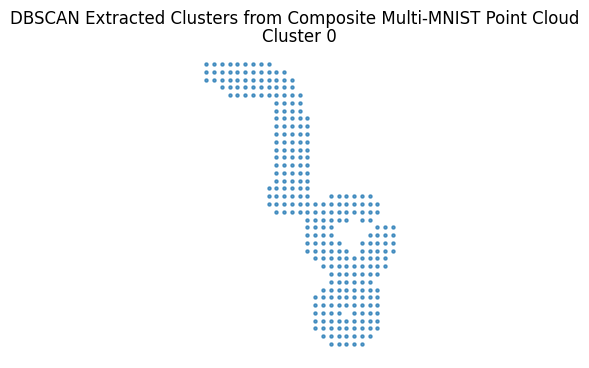

In [18]:
# %% [code]
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Assume 'pointcloud' is the point cloud obtained from a composite multi-MNIST image (with 2 digits)
# For example, pointcloud was generated in a previous cell using image_to_pointcloud().
# We now use DBSCAN to cluster these points.
dbscan = DBSCAN(eps=2, min_samples=10)  # These parameters may need tuning for your dataset.
cluster_labels = dbscan.fit_predict(pointcloud)

# Print unique cluster labels (excluding noise which is labeled as -1)
unique_clusters = [label for label in np.unique(cluster_labels) if label != -1]
print("Unique clusters found (excluding noise):", unique_clusters)

# If no clusters found, then adjust DBSCAN parameters.
if len(unique_clusters) == 0:
    print("No clusters found. Consider tuning DBSCAN parameters.")
else:
    # Visualize each cluster in its own subplot.
    num_clusters = len(unique_clusters)
    fig, axes = plt.subplots(1, num_clusters, figsize=(4*num_clusters, 4))
    if num_clusters == 1:
        axes = [axes]  # Ensure axes is iterable.
    
    for i, cluster_label in enumerate(unique_clusters):
        # Select points belonging to the current cluster.
        cluster_points = pointcloud[cluster_labels == cluster_label]
        axes[i].scatter(cluster_points[:, 1], -cluster_points[:, 0], s=5, alpha=0.7)
        axes[i].set_title(f"Cluster {cluster_label}")
        axes[i].axis('equal')
        axes[i].axis('off')
    
    plt.suptitle("DBSCAN Extracted Clusters from Composite Multi-MNIST Point Cloud")
    plt.show()


In [19]:
# %% [code]
import torch

# Create a dictionary to store latent codes for each digit (0-9)
latent_codes_by_digit = {d: [] for d in range(10)}

# Set the model to evaluation mode and disable gradient computation
model.eval()
with torch.no_grad():
    # Loop over all samples in the MNISTPointCloudDataset
    for padded, label, length in dataset:
        # Extract the valid points from the padded point cloud.
        valid_points = padded[:length]
        # Forward pass through the model.
        zs, _, _ = model(valid_points)
        # Take the final latent representation (shape: [N, 2])
        latent = zs[-1]
        # Compute the average latent code for the sample (resulting in shape: [2])
        avg_latent = latent.mean(dim=0)
        # Append the average latent code to the corresponding digit list
        latent_codes_by_digit[label].append(avg_latent)
        
# Optionally, stack the latent codes for each digit into a single tensor.
for d in range(10):
    if latent_codes_by_digit[d]:
        latent_codes_by_digit[d] = torch.stack(latent_codes_by_digit[d])
    else:
        print(f"No samples found for digit {d}.")

# Print out the shapes for verification
print("Latent codes computed for each digit:")
for d in range(10):
    if isinstance(latent_codes_by_digit[d], torch.Tensor):
        print(f"Digit {d}: {latent_codes_by_digit[d].shape}")
    else:
        print(f"Digit {d}: No latent codes stored.")


Latent codes computed for each digit:
Digit 0: torch.Size([5923, 2])
Digit 1: torch.Size([6742, 2])
Digit 2: torch.Size([5958, 2])
Digit 3: torch.Size([6131, 2])
Digit 4: torch.Size([5842, 2])
Digit 5: torch.Size([5421, 2])
Digit 6: torch.Size([5918, 2])
Digit 7: torch.Size([6265, 2])
Digit 8: torch.Size([5851, 2])
Digit 9: torch.Size([5949, 2])


Collected 1000 point clouds for digit 0
Collected 1000 point clouds for digit 1
Collected 1000 point clouds for digit 2
Collected 1000 point clouds for digit 3
Collected 1000 point clouds for digit 4
Collected 1000 point clouds for digit 5
Collected 1000 point clouds for digit 6
Collected 1000 point clouds for digit 7
Collected 1000 point clouds for digit 8
Collected 1000 point clouds for digit 9
Saved all digit point clouds to 'all_digit_pointclouds.pkl'


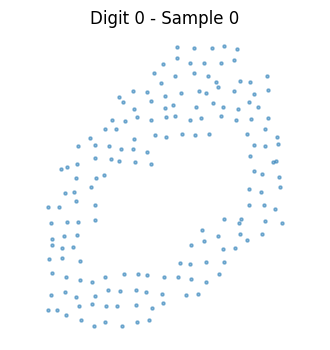

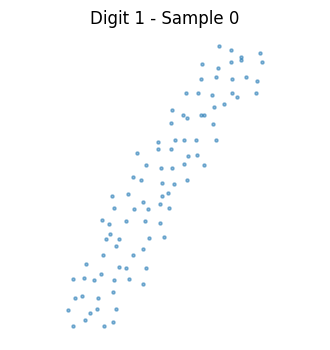

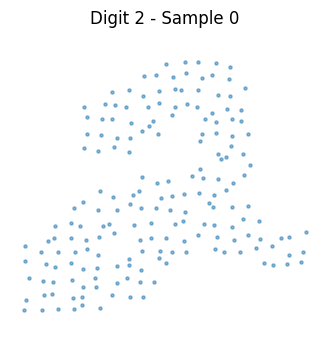

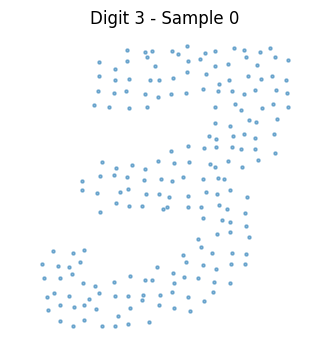

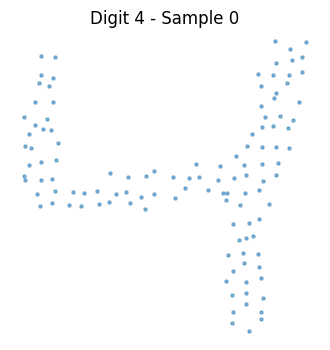

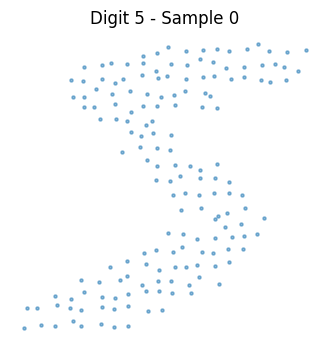

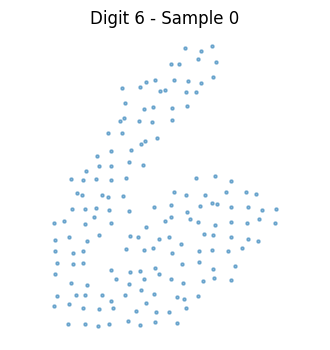

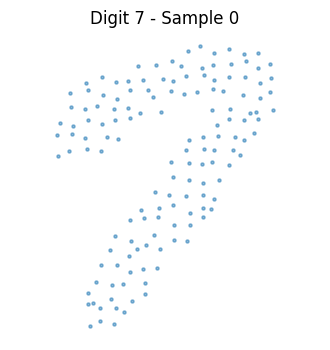

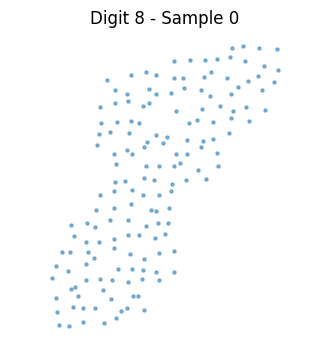

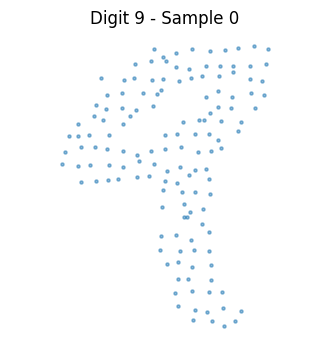

In [20]:
# %% [code]
import pickle
import numpy as np

# Create a dictionary to store point clouds for each digit (0-9)
all_digit_pointclouds = {d: [] for d in range(10)}

# Target: collect up to 1000 point clouds per digit (adjust if needed)
target_samples = 1000

# Loop over the dataset and group point clouds by their digit label
for idx in range(len(dataset)):
    padded, label, length = dataset[idx]
    # Convert to NumPy (using valid, unpadded points)
    pointcloud = padded[:length].detach().cpu().numpy()
    # Append only if we haven't reached the target for this digit
    if len(all_digit_pointclouds[label]) < target_samples:
        all_digit_pointclouds[label].append(pointcloud)
    # Break early if all digits have reached the target
    if all(len(all_digit_pointclouds[d]) >= target_samples for d in range(10)):
        break

# Print how many point clouds were collected for each digit
for d in range(10):
    print(f"Collected {len(all_digit_pointclouds[d])} point clouds for digit {d}")

# Save the dictionary to a pickle file
with open('all_digit_pointclouds.pkl', 'wb') as f:
    pickle.dump(all_digit_pointclouds, f)
print("Saved all digit point clouds to 'all_digit_pointclouds.pkl'")

# Visualize one sample per digit as a sanity check (here, the first sample for each digit)
for d in range(10):
    visualize_pointcloud(all_digit_pointclouds[d][0], title=f"Digit {d} - Sample 0")


Digit 0: concatenated shape = (194879, 2)
Digit 1: concatenated shape = (88499, 2)
Digit 2: concatenated shape = (167765, 2)
Digit 3: concatenated shape = (164469, 2)
Digit 4: concatenated shape = (141971, 2)
Digit 5: concatenated shape = (149531, 2)
Digit 6: concatenated shape = (156078, 2)
Digit 7: concatenated shape = (132961, 2)
Digit 8: concatenated shape = (173129, 2)
Digit 9: concatenated shape = (144357, 2)


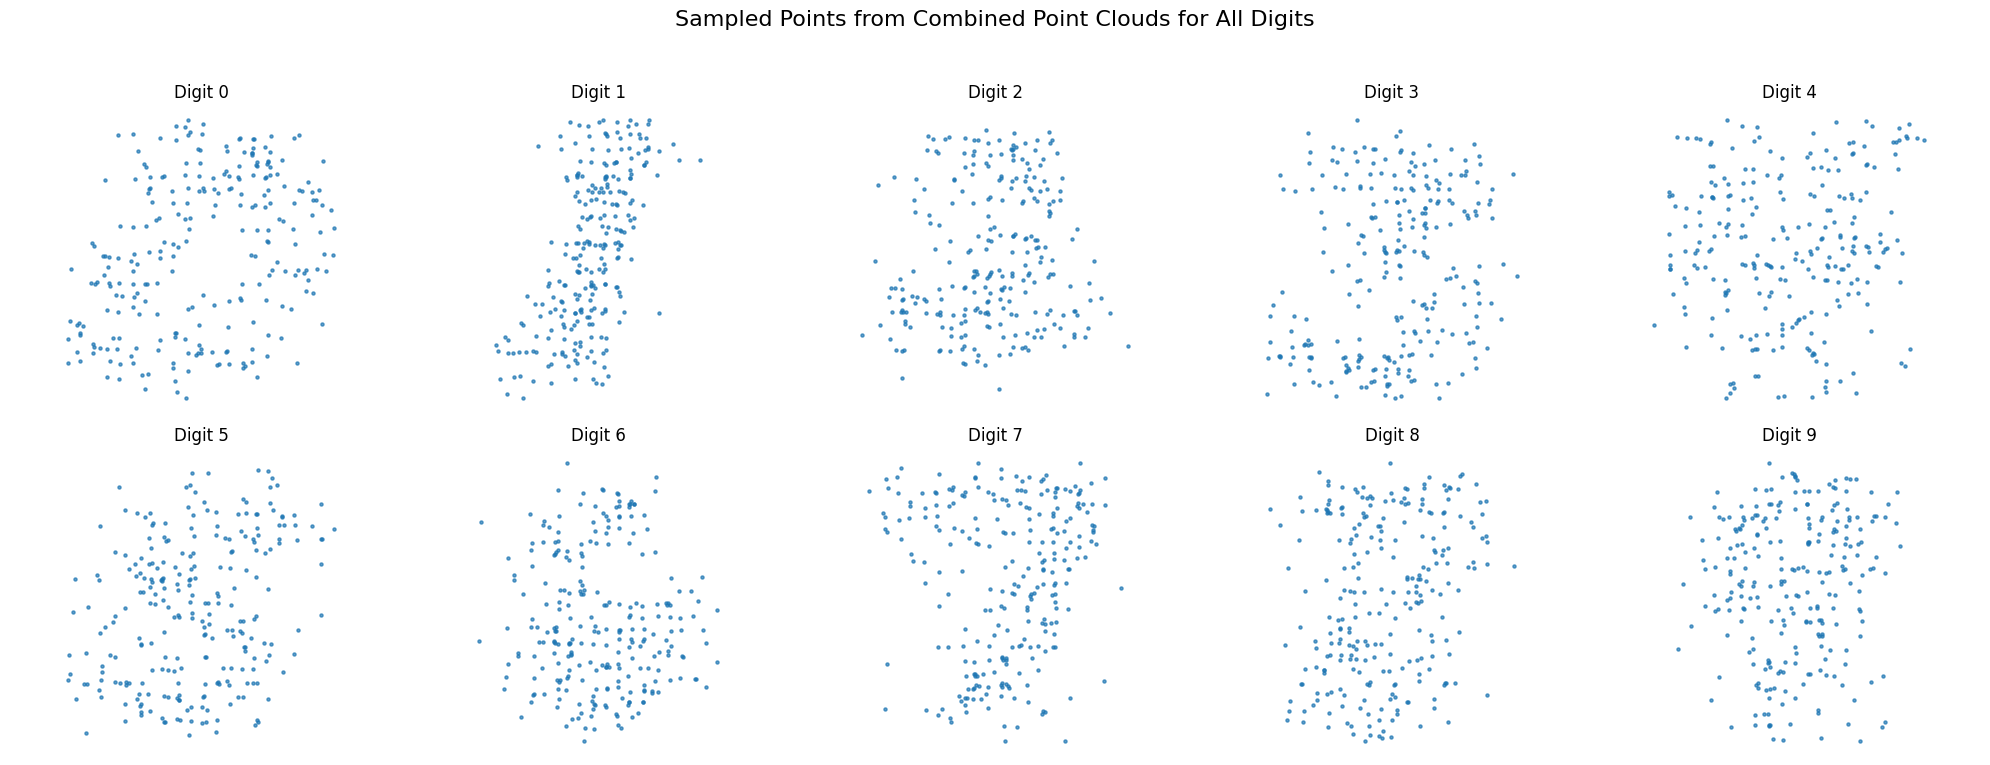

In [22]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load the saved point clouds for all digits from a pickle file.
# The file is assumed to contain a dictionary with keys 0-9,
# where each value is a list of point clouds (each as a NumPy array) for that digit.
with open('all_digit_pointclouds.pkl', 'rb') as f:
    all_digit_pointclouds = pickle.load(f)

# Create a figure with 2 rows and 5 columns (one subplot per digit)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Loop over each digit (0 to 9)
for d in range(10):
    # Retrieve the list of point clouds for digit d and concatenate them
    digit_pointclouds = all_digit_pointclouds[d]
    concatenated = np.concatenate(digit_pointclouds, axis=0)
    print(f"Digit {d}: concatenated shape = {concatenated.shape}")
    
    # Randomly sample 128 points from the concatenated array
    num_sample = 256
    indices = np.random.choice(concatenated.shape[0], size=num_sample, replace=False)
    sampled_points = concatenated[indices]
    
    # Plot the sampled points
    axes[d].scatter(sampled_points[:, 1], -sampled_points[:, 0], s=5, alpha=0.7)
    axes[d].set_title(f"Digit {d}")
    axes[d].axis('equal')
    axes[d].axis('off')

plt.suptitle("Sampled Points from Combined Point Clouds for All Digits", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [23]:
# %% [code]
import pickle
import numpy as np
import itertools
import torch
import torch.optim as optim
from torch.distributions import Uniform, TransformedDistribution, SigmoidTransform
from nflib.flows import NormalizingFlowModel, Invertible1x1Conv, ActNorm
from nflib.spline_flows import NSF_CL

# Load the dictionary of point clouds for all digits
with open('all_digit_pointclouds.pkl', 'rb') as f:
    all_digit_pointclouds = pickle.load(f)

# Concatenate all point clouds for all digits into one large array
all_points_list = []
for d in range(10):
    digit_pointclouds = all_digit_pointclouds[d]
    # Concatenate the point clouds for each digit
    all_points_list.append(np.concatenate(digit_pointclouds, axis=0))
all_points = np.concatenate(all_points_list, axis=0)
print("Total number of points in concatenated all-digit point clouds:", all_points.shape[0])
all_points_tensor = torch.from_numpy(all_points.astype(np.float32))

# Build the prior distribution (logistic-like)
prior = TransformedDistribution(
    Uniform(torch.zeros(2), torch.ones(2)),
    SigmoidTransform().inv
)

# Construct flow layers using neural spline flows (NSF_CL) with Invertible1x1Conv and ActNorm layers
nfs_flow = NSF_CL
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flow_layers = list(itertools.chain(*zip(norms, convs, flows)))

# Construct the overall model
model = NormalizingFlowModel(prior, flow_layers)

# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("Number of parameters in the model:", sum(p.numel() for p in model.parameters()))

# Training loop on all-digit point clouds
model.train()
num_iterations = 1000  # Adjust as needed

for i in range(num_iterations):
    # Randomly sample 128 points from the combined all-digit tensor
    indices = torch.randint(0, all_points_tensor.shape[0], (128,))
    x = all_points_tensor[indices]
    
    # Forward pass through the model
    zs, prior_logprob, log_det = model(x)
    loss = -torch.sum(prior_logprob + log_det)  # Negative log-likelihood
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.2f}")


Total number of points in concatenated all-digit point clouds: 1513639
Number of parameters in the model: 5844
Iteration 0: Loss = 838.87
Iteration 100: Loss = 816.35
Iteration 200: Loss = 810.79
Iteration 300: Loss = 807.26
Iteration 400: Loss = 787.26
Iteration 500: Loss = 789.18
Iteration 600: Loss = 768.78
Iteration 700: Loss = 767.38
Iteration 800: Loss = 782.54
Iteration 900: Loss = 785.38


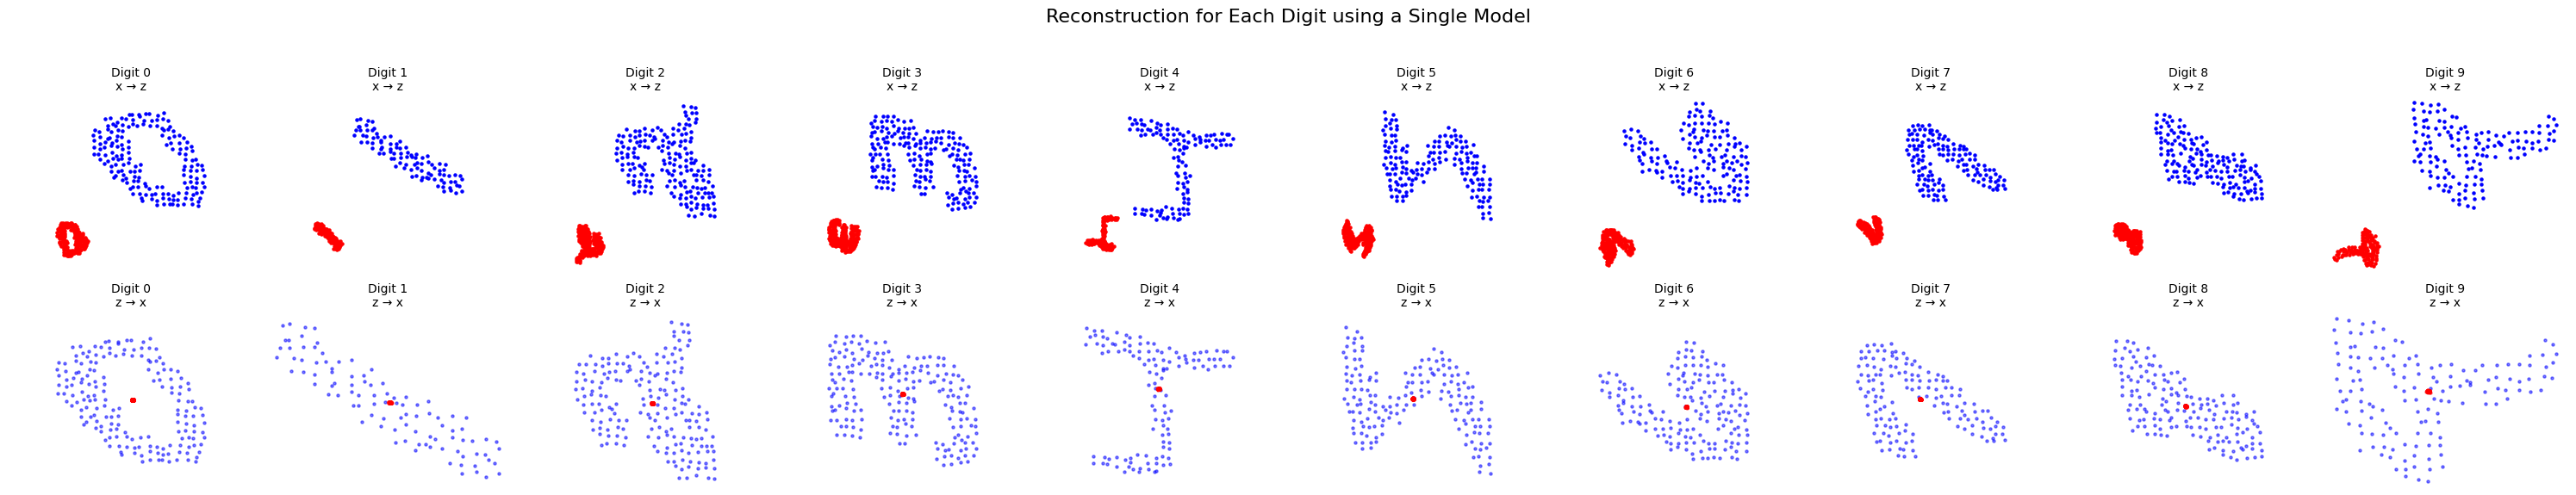

In [24]:
# %% [code]
import matplotlib.pyplot as plt
import torch

model.eval()
digits = list(range(10))

# Create a 2x10 grid: top row for x→z mapping, bottom row for z→x reconstruction.
fig, axes = plt.subplots(2, 10, figsize=(30, 6))

for idx, d in enumerate(digits):
    # Find the first sample in the dataset with label equal to d.
    for sample, label, length in dataset:
        if label == d:
            x = sample[:length]  # x is a tensor of shape [N, 2]
            break

    # Forward pass: map x to latent space z.
    zs, _, _ = model(x)
    z = zs[-1]
    
    # Convert x and z to NumPy arrays for visualization.
    x_np = x.detach().cpu().numpy()
    z_np = z.detach().cpu().numpy()
    
    # ---- Reconstruction (Inverse Mapping) ----
    # To reconstruct, we use the latent code from the forward pass.
    # Since the model is unconditional, we add a small amount of noise to generate variation.
    latent_noise_std = 0.01
    noise = latent_noise_std * torch.randn(x.shape[0], 2)
    # For reconstruction, we use the average latent code of the sample plus noise.
    latent_code = z.mean(dim=0, keepdim=True).repeat(x.shape[0], 1) + noise
    zs_inv, _ = model.backward(latent_code)
    x_rec = zs_inv[-1].detach().cpu().numpy()
    
    # ---- Plotting ----
    # Top row: x→z mapping (data, latent codes, and prior samples for reference)
    axes[0, idx].scatter(x_np[:, 0], x_np[:, 1], c='b', s=5, label='data')
    axes[0, idx].scatter(z_np[:, 0], z_np[:, 1], c='r', s=5, label='x→z')
    axes[0, idx].set_title(f"Digit {d}\nx → z", fontsize=10)
    axes[0, idx].axis('equal')
    axes[0, idx].axis('off')
    
    # Bottom row: z→x mapping (original data vs. reconstructed)
    axes[1, idx].scatter(x_np[:, 0], x_np[:, 1], c='b', s=5, alpha=0.5, label='data')
    axes[1, idx].scatter(x_rec[:, 0], x_rec[:, 1], c='r', s=5, alpha=0.5, label='z → x')
    axes[1, idx].set_title(f"Digit {d}\nz → x", fontsize=10)
    axes[1, idx].axis('equal')
    axes[1, idx].axis('off')

plt.suptitle("Reconstruction for Each Digit using a Single Model", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


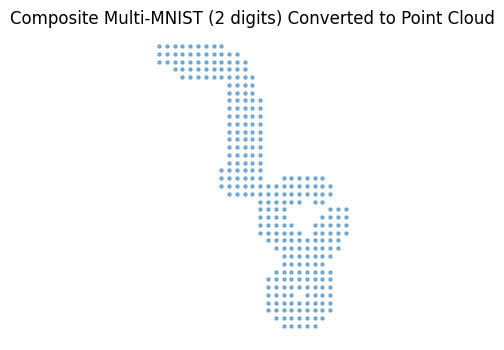

In [25]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

# Here we assume that you have already generated the composite multi-MNIST images
# with 2 digits per image in the previous cell and stored them in the list `multi_mnist_images`.
# If you haven't, you can regenerate them as shown in the previous cell.
#
# We'll reuse the conversion logic from our earlier function (adapted for any image).

def image_to_pointcloud(image, threshold=0, noise_std=0.1):
    """
    Convert an image to a point cloud by extracting the (row, col) coordinates
    of pixels with values above the threshold.
    
    Args:
        image (np.ndarray): 2D image array.
        threshold (int): Pixels above this value are considered 'on'.
        noise_std (float): Standard deviation for Gaussian noise.
        
    Returns:
        np.ndarray: Array of shape [N, 2] with (row, col) coordinates.
    """
    row_indices, col_indices = np.where(image > threshold)
    coords = np.stack((row_indices, col_indices), axis=-1).astype(np.float32)
    if noise_std > 0:
        noise = np.random.normal(loc=0.0, scale=noise_std, size=coords.shape)
        coords += noise
    return coords

# For demonstration, convert the first composite multi-MNIST image to a point cloud.
composite_image = multi_mnist_images[0]  # Assuming multi_mnist_images is defined from the previous cell
pointcloud = image_to_pointcloud(composite_image, threshold=0, noise_std=0.0)

# Visualize the converted point cloud
plt.figure(figsize=(4,4))
plt.scatter(pointcloud[:, 1], -pointcloud[:, 0], s=5, alpha=0.5)
plt.title("Composite Multi-MNIST (2 digits) Converted to Point Cloud")
plt.axis('equal')
plt.axis('off')
plt.show()


Unique clusters found (excluding noise): [0]


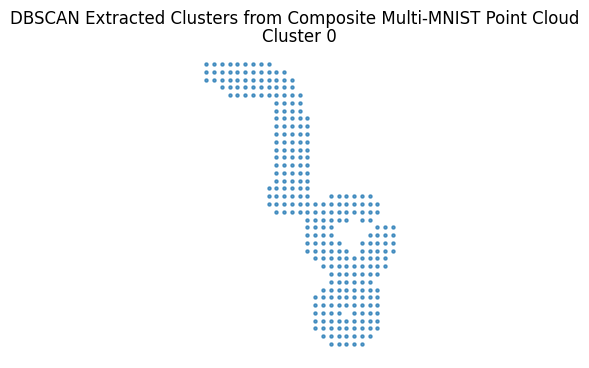

In [26]:
# %% [code]
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Assume 'pointcloud' is the point cloud obtained from a composite multi-MNIST image (with 2 digits)
# For example, pointcloud was generated in a previous cell using image_to_pointcloud().
# We now use DBSCAN to cluster these points.
dbscan = DBSCAN(eps=2, min_samples=10)  # These parameters may need tuning for your dataset.
cluster_labels = dbscan.fit_predict(pointcloud)

# Print unique cluster labels (excluding noise which is labeled as -1)
unique_clusters = [label for label in np.unique(cluster_labels) if label != -1]
print("Unique clusters found (excluding noise):", unique_clusters)

# If no clusters found, then adjust DBSCAN parameters.
if len(unique_clusters) == 0:
    print("No clusters found. Consider tuning DBSCAN parameters.")
else:
    # Visualize each cluster in its own subplot.
    num_clusters = len(unique_clusters)
    fig, axes = plt.subplots(1, num_clusters, figsize=(4*num_clusters, 4))
    if num_clusters == 1:
        axes = [axes]  # Ensure axes is iterable.
    
    for i, cluster_label in enumerate(unique_clusters):
        # Select points belonging to the current cluster.
        cluster_points = pointcloud[cluster_labels == cluster_label]
        axes[i].scatter(cluster_points[:, 1], -cluster_points[:, 0], s=5, alpha=0.7)
        axes[i].set_title(f"Cluster {cluster_label}")
        axes[i].axis('equal')
        axes[i].axis('off')
    
    plt.suptitle("DBSCAN Extracted Clusters from Composite Multi-MNIST Point Cloud")
    plt.show()


In [29]:
# %% [code]
import torch
import numpy as np

# 1. For each digit from the MNIST dataset, find the first sample and print its shape.
print("Dimensions of individual MNIST point cloud samples:")
for d in range(10):
    for sample, label, length in dataset:
        if label == d:
            # Extract valid points from the padded point cloud
            x = sample[:length]  # x is a tensor of shape [N, 2]
            print(f"Digit {d}: {x.shape}")  # e.g. torch.Size([166, 2])
            break

# 2. For the composite multi-MNIST point cloud:
# Assume 'pointcloud' is the composite point cloud (a NumPy array) obtained from image_to_pointcloud() of a multi-digit image.
print("\nDimension of composite multi-MNIST point cloud:")
print("pointcloud shape:", pointcloud.shape)

# Apply DBSCAN (we assume this was already done) and print the shape of one extracted cluster.
# For example, pick the first unique cluster (excluding noise)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=10)
cluster_labels = dbscan.fit_predict(pointcloud)
unique_clusters = [label for label in np.unique(cluster_labels) if label != -1]
if len(unique_clusters) > 0:
    first_cluster = pointcloud[cluster_labels == unique_clusters[0]]
    print(f"Dimension of extracted cluster (label {unique_clusters[0]}):", first_cluster.shape)
else:
    print("No clusters found.")


Dimensions of individual MNIST point cloud samples:
Digit 0: torch.Size([176, 2])
Digit 1: torch.Size([96, 2])
Digit 2: torch.Size([188, 2])
Digit 3: torch.Size([200, 2])
Digit 4: torch.Size([120, 2])
Digit 5: torch.Size([166, 2])
Digit 6: torch.Size([168, 2])
Digit 7: torch.Size([144, 2])
Digit 8: torch.Size([161, 2])
Digit 9: torch.Size([142, 2])

Dimension of composite multi-MNIST point cloud:
pointcloud shape: (292, 2)
Dimension of extracted cluster (label 0): (292, 2)


In [30]:
# %% [code]
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode

# Parameters for normalization:
# Assume the composite image is 56x56 (pixel coordinates 0 to 55) and the model expects inputs in [-3,3].
canvas_size = 56.0  # maximum pixel value + 1 is 56
B = 3.0             # tail bound (i.e. expected range is [-3, 3])

# Extract the points for a chosen cluster (for example, cluster with label 0)
cluster_points = pointcloud[cluster_labels == unique_clusters[0]]
print("Original cluster shape (NumPy):", cluster_points.shape)

# Normalize the cluster points from [0, canvas_size-1] to [-B, B]
# Formula: x_norm = (x / (canvas_size-1)) * (2B) - B
cluster_points_norm = (cluster_points / (canvas_size - 1)) * (2 * B) - B

# Convert normalized cluster points to a torch tensor with shape [N, 2]
x_cluster = torch.from_numpy(cluster_points_norm).float()
print("Converted tensor shape:", x_cluster.shape)

# Forward mapping: x → z
zs, _, _ = model(x_cluster)
z_cluster = zs[-1]
print("Latent representation shape:", z_cluster.shape)

# Inverse mapping: z → x (Reconstruction)
zs_inv, _ = model.backward(z_cluster)
x_reconstructed_norm = zs_inv[-1].detach().cpu().numpy()
print("Reconstructed cluster shape:", x_reconstructed_norm.shape)

# (Optional) To visualize in original pixel coordinates, invert the normalization:
# x_orig = ((x_norm + B) / (2*B)) * (canvas_size - 1)
x_reconstructed = ((x_reconstructed_norm + B) / (2 * B)) * (canvas_size - 1)

# Visualization: Plot original normalized cluster vs. reconstructed (back-converted) cluster
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(cluster_points_norm[:, 1], -cluster_points_norm[:, 0], s=5, alpha=0.7)
plt.title("Original Normalized Cluster")
plt.axis('equal')
plt.axis('off')

plt.subplot(122)
plt.scatter(x_reconstructed[:, 1], -x_reconstructed[:, 0], s=5, alpha=0.7)
plt.title("Reconstructed (Back-converted) Cluster")
plt.axis('equal')
plt.axis('off')

plt.suptitle("Cluster Reconstruction after Normalization & Mapping", fontsize=14)
plt.show()

# Print dimensions for clarity
print("Original normalized cluster shape:", cluster_points_norm.shape)
print("Latent representation shape:", z_cluster.shape)
print("Reconstructed normalized cluster shape:", x_reconstructed_norm.shape)


Original cluster shape (NumPy): (292, 2)
Converted tensor shape: torch.Size([292, 2])


RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [31]:
# Normalize x_cluster_tensor from [0, canvas_size-1] to [-B, B]
canvas_size = 56.0
B = 3.0
x_cluster_norm = (x_cluster_tensor / (canvas_size - 1)) * (2 * B) - B

print("Normalized x_cluster_norm:")
print(x_cluster_norm)
print("Min, max:", x_cluster_norm.min().item(), x_cluster_norm.max().item())

# Forward pass through the model using the normalized tensor
zs, prior_logprob, log_det = model(x_cluster_norm)
z_cluster = zs[-1]
print("Latent representation shape:", z_cluster.shape)

NameError: name 'x_cluster_tensor' is not defined